In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import joblib
from pathlib import Path
from aerosandbox import Airfoil, KulfanAirfoil

# Find the project root (the nearest ancestor that contains `src`) and add it to sys.path
cwd = Path.cwd()
project_root = cwd
for _ in range(6):
    if (project_root / "src").exists():
        break
    if project_root.parent == project_root:
        break
    project_root = project_root.parent
else:
    project_root = cwd

proj_path = str(project_root.resolve())
if proj_path not in sys.path:
    # Insert at front so local packages take precedence
    sys.path.insert(0, proj_path)

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from IPython.display import Image, display

from src.vae import CSTVariationalAutoencoder
from src.plotting import plot_original_and_reconstruction
from src.layers.airfoil_scaler import AirfoilScaler
from src.plotting import *
from src.utils import compute_vod_loss, compute_vod_numpy

from src.airfoil import airfoil_modifications

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

2026-02-03 16:50:27.378374: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-03 16:50:28.652439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-03 16:50:32.463512: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
# ============================================================================
# USER INPUTS
# ============================================================================

# 1. The timestamp folder name in models/cstvae/
RUN_ID = "20260201-233018"  

# 2. The specific epoch number to load
EPOCH = 500                 

# 3. Model Hyperparameters (Must match what was used in training)
NPV = 12
LATENT_DIM = 16

# 4. Number of airfoils to plot during validation
AIRFOILS_TO_PLOT = 16

# Paths
BASE_DIR = Path(proj_path) # Project Root
MODELS_DIR = BASE_DIR / "models" / "cstvae" / RUN_ID
WEIGHTS_PATH = MODELS_DIR / "weights" / f"vae_weights_epoch_{EPOCH}.weights.h5"
SCALER_PATH = MODELS_DIR / "scaler" / "scaler.pkl"
TRAIN_DATA_PATH = BASE_DIR / "data" / "processed" / "train_kulfan_dataset_75.json"
DATA_PATH = BASE_DIR / "data" / "processed" / "val_kulfan_dataset_75.json"

print(f"Loading model from: {RUN_ID}")
print(f"Weights file: {WEIGHTS_PATH}")

Loading model from: 20260201-233018
Weights file: /home/matsouto/py/Generative_airfoil_models/models/cstvae/20260201-233018/weights/vae_weights_epoch_500.weights.h5


In [4]:
# 1. Load the Scaler
if not SCALER_PATH.exists():
    raise FileNotFoundError(f"Scaler not found at {SCALER_PATH}")

print("Loading Scaler...")
scaler = joblib.load(SCALER_PATH)

# 2. Instantiate the VAE Model
print("Building VAE Architecture...")
vae = CSTVariationalAutoencoder(scaler=scaler, npv=NPV, latent_dim=LATENT_DIM)

# 3. Run a dummy forward pass to initialize the graph
# (TensorFlow needs to know input shape to build layers before loading weights)
dummy_input = tf.zeros((1, 26)) 
vae(dummy_input)

# 4. Load Weights
print(f"Loading Weights from Epoch {EPOCH}...")
try:
    vae.load_weights(WEIGHTS_PATH)
    print("✓ Weights loaded successfully.")
except OSError as e:
    print(f"❌ Error loading weights: {e}")
    print("Check if the file path is correct.")

Loading Scaler...
Building VAE Architecture...


2026-02-03 16:50:37.004113: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/matsouto/py/Generative_airfoil_models/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/matsouto/py/Generative_airfoil_models/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may 

Loading Weights from Epoch 500...
✓ Weights loaded successfully.


In [5]:
# 1. Load Dataframe
print("Loading Validation Dataset...")
val_df = pd.read_json(DATA_PATH)

# 2. Select First 9 Airfoils
val_sample = val_df.iloc[:AIRFOILS_TO_PLOT].copy().reset_index(drop=True)

# 3. Helper to format coordinates
val_sample["coordinates"] = val_sample["coordinates"].apply(np.array)

# 4. Extract Kulfan Parameters (Exact logic from train.py)
# Note: Ensure order (lower vs upper) matches your training script exactly
raw_vectors = val_sample["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["upper_weights"],     # Upper
    p["lower_weights"],     # Lower
    [p["TE_thickness"]],    # TE
    [p["leading_edge_weight"]] # LE
    ], axis=0)).to_list()

# 5. Normalize
raw_tensor = tf.convert_to_tensor(raw_vectors, dtype=tf.float32)
weights_raw = raw_tensor[:, :24]
params_raw = raw_tensor[:, 24:]
input_normalized = scaler.transform(weights_raw, params_raw)

print(f"✓ Data prepared. Input shape: {input_normalized.shape}")

Loading Validation Dataset...
✓ Data prepared. Input shape: (16, 26)


Running Inference...
Preparing Airfoil objects...
Generating Plots...


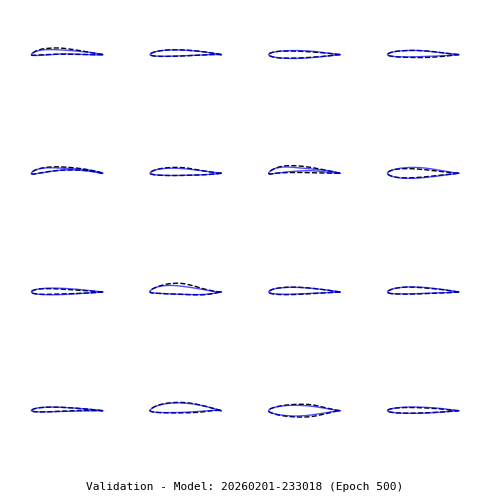

In [6]:
# 1. Run Inference (Reconstruction)
print("Running Inference...")
# training=False removes stochastic noise for validation
_, pred_weights_norm, pred_params_norm = vae(input_normalized, training=False)

# 2. Denormalize Predictions
pred_weights, pred_params = scaler.inverse_transform(
    pred_weights_norm.numpy(), 
    pred_params_norm.numpy()
)

# 3. Generate Coordinates via CST Layer
pred_coords = vae.decoder.cst_transform(
    tf.convert_to_tensor(pred_weights, dtype=tf.float32), 
    tf.convert_to_tensor(pred_params, dtype=tf.float32)
).numpy()

# 4. Prepare Airfoil Objects for the Plotter
print("Preparing Airfoil objects...")

# List A: Original Ground Truth Airfoils (created in Cell 4)
# (Assuming 'validation_airfoils' list was created in Cell 4 logic, 
#  if not, we recreate it here from the dataframe sample)
original_airfoils_objs = [
    Airfoil(coordinates=row["coordinates"], name=row["airfoil_name"]) 
    for _, row in val_sample.iterrows()
]

# List B: Reconstructed Airfoils from VAE
reconstructed_airfoils_objs = []
for coords in pred_coords:
    # We assign a generic name or copy the original name for reference
    reconstructed_airfoils_objs.append(Airfoil(coordinates=coords, name="VAE Reco"))

# 5. Call Your Custom Plot Function
print("Generating Plots...")
plot_original_and_reconstruction(
    original_airfoils_objs,       # Ground Truth
    reconstructed_airfoils_objs,  # VAE Output
    text_label=f"Validation - Model: {RUN_ID} (Epoch {EPOCH})",
    save_path=None,               # Set to None to strictly show in notebook
    filename=None,
    show=True                     # Force show in notebook
)

### Errors

Calculating metrics for entire validation set (182 samples)...
Generating coordinates for geometric error calculation...

GLOBAL VALIDATION RESULTS (Model: 20260201-233018)
Weights MAE (Normalized):  0.015145
Geometric MAE (Physical):  0.001972


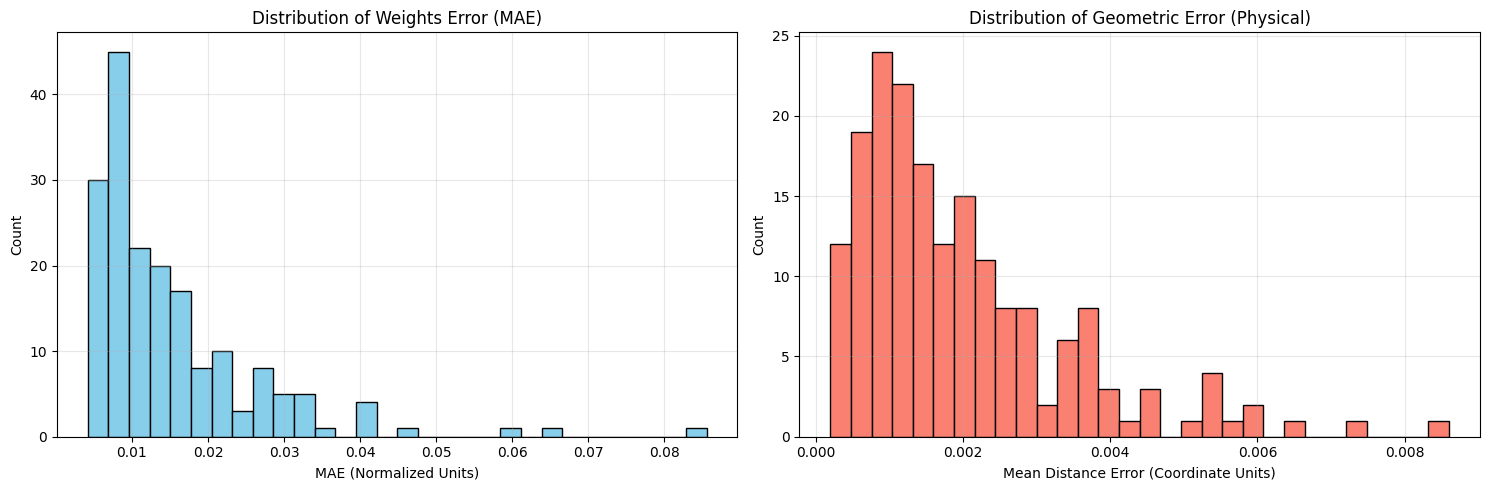

In [7]:
# ============================================================================
# GLOBAL VALIDATION METRICS (WEIGHTS + GEOMETRY)
# ============================================================================

print(f"Calculating metrics for entire validation set ({len(val_df)} samples)...")

# 1. Prepare Full Input Tensor (Raw Physical Values)
# Extract all vectors using the same logic as before
all_vectors = val_df["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["upper_weights"],     # Upper
    p["lower_weights"],     # Lower
    [p["TE_thickness"]],    # TE
    [p["leading_edge_weight"]] # LE
    ], axis=0)).to_list()

# Convert to Tensor (Physical Units)
all_tensor_phys = tf.convert_to_tensor(all_vectors, dtype=tf.float32)
all_weights_phys = all_tensor_phys[:, :24]
all_params_phys = all_tensor_phys[:, 24:]

# Normalize for Model Input
all_normalized = scaler.transform(all_weights_phys, all_params_phys)

# 2. Run Inference on the whole batch
# training=False ensures deterministic output
_, pred_w_norm, pred_p_norm = vae(all_normalized, training=False)

# ---------------------------------------------------------
# METRIC A: WEIGHTS MAE (Mathematical Error)
# ---------------------------------------------------------
# Reshape VAE output to match input shape (Batch, 26)
pred_w_flat = tf.reshape(pred_w_norm, [-1, 24]) 
pred_combined_norm = tf.concat([pred_w_flat, pred_p_norm], axis=1)

# Calculate MAE
mae_metric = tf.keras.losses.MeanAbsoluteError()
global_mae = mae_metric(all_normalized, pred_combined_norm).numpy()

# Calculate per-sample error for histogram
errors_weights = tf.reduce_mean(tf.abs(all_normalized - pred_combined_norm), axis=1).numpy()

# ---------------------------------------------------------
# METRIC B: GEOMETRIC MAE (Physical Error)
# ---------------------------------------------------------
print("Generating coordinates for geometric error calculation...")

# A. Generate Ground Truth Coordinates
# Reshape weights to (Batch, 2, 12) for CST Layer
true_weights_reshaped = tf.reshape(all_weights_phys, [-1, 2, 12])
true_coords = vae.decoder.cst_transform(true_weights_reshaped, all_params_phys)

# B. Generate Predicted Coordinates
# Denormalize predictions back to physical units
pred_w_phys, pred_p_phys = vae.scaler.inverse_transform(
    pred_w_norm.numpy(), 
    pred_p_norm.numpy()
)
# Convert to Tensor and Reshape
pred_w_phys_t = tf.convert_to_tensor(pred_w_phys, dtype=tf.float32)
pred_w_phys_reshaped = tf.reshape(pred_w_phys_t, [-1, 2, 12])
pred_p_phys_t = tf.convert_to_tensor(pred_p_phys, dtype=tf.float32)

pred_coords = vae.decoder.cst_transform(pred_w_phys_reshaped, pred_p_phys_t)

# C. Calculate Geometric MAE
# Mean absolute difference between coordinates
val_geo_mae = tf.reduce_mean(tf.abs(true_coords - pred_coords)).numpy()

# Calculate per-sample geometric error for histogram
errors_geo = tf.reduce_mean(tf.reduce_mean(tf.abs(true_coords - pred_coords), axis=1), axis=1).numpy()

# ---------------------------------------------------------
# RESULTS & PLOTTING
# ---------------------------------------------------------
print("\n" + "="*40)
print(f"GLOBAL VALIDATION RESULTS (Model: {RUN_ID})")
print("="*40)
print(f"Weights MAE (Normalized):  {global_mae:.6f}")
print(f"Geometric MAE (Physical):  {val_geo_mae:.6f}")
print("="*40)

# Plot Histograms
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Weights Error
ax[0].hist(errors_weights, bins=30, color='skyblue', edgecolor='black')
ax[0].set_title("Distribution of Weights Error (MAE)")
ax[0].set_xlabel("MAE (Normalized Units)")
ax[0].set_ylabel("Count")
ax[0].grid(True, alpha=0.3)

# Plot 2: Geometric Error
ax[1].hist(errors_geo, bins=30, color='salmon', edgecolor='black')
ax[1].set_title("Distribution of Geometric Error (Physical)")
ax[1].set_xlabel("Mean Distance Error (Coordinate Units)")
ax[1].set_ylabel("Count")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Valid Airfoil Rate

In [8]:
BATCH_SIZE = 5000

dummy_latent_vector = tf.random.normal((BATCH_SIZE, LATENT_DIM))

_, w_norm, p_norm = vae.decoder(dummy_latent_vector)

w_norm = tf.reshape(w_norm, [-1, 2 * NPV])

w_phys, p_phys = vae.scaler.inverse_transform(w_norm.numpy(), p_norm.numpy())

w_phys_t = tf.convert_to_tensor(w_phys, dtype=tf.float32)
p_phys_t = tf.convert_to_tensor(p_phys, dtype=tf.float32)

# Reformatamos para (1000, 2, 12) para a camada CST desenhar
w_phys_reshaped = tf.reshape(w_phys_t, [-1, 2, 12])

coords = vae.decoder.cst_transform(w_phys_reshaped, p_phys_t).numpy()

def check_validity(coords):
    x = coords[:, 0]
    y = coords[:, 1]
    le_idx = np.argmin(x)
    
    # Separa superfícies
    upper_y = y[:le_idx+1][::-1]
    lower_y = y[le_idx:]

    # Check: Espessura negativa (tolerância 1e-4)
    thickness = upper_y - lower_y
    if np.any(thickness < -1e-4):
        return False
        
    return True

# Executar Contagem
valid_count = 0
for i in range(BATCH_SIZE):
    if check_validity(coords[i]):
        valid_count += 1

validity_rate = (valid_count / BATCH_SIZE) * 100

print("\n" + "="*40)
print(f"VALID AIRFOIL RATE")
print("="*40)
print(f"Total Generated: {BATCH_SIZE}")
print(f"Valid Airfoils:  {valid_count}")
print(f"Success Rate:    {validity_rate:.2f}%")
print("="*40)


VALID AIRFOIL RATE
Total Generated: 5000
Valid Airfoils:  4582
Success Rate:    91.64%


Identificando perfis inválidos...
Encontrados 38 perfis inválidos.
Muitos erros (38). Plotando os primeiros 16...


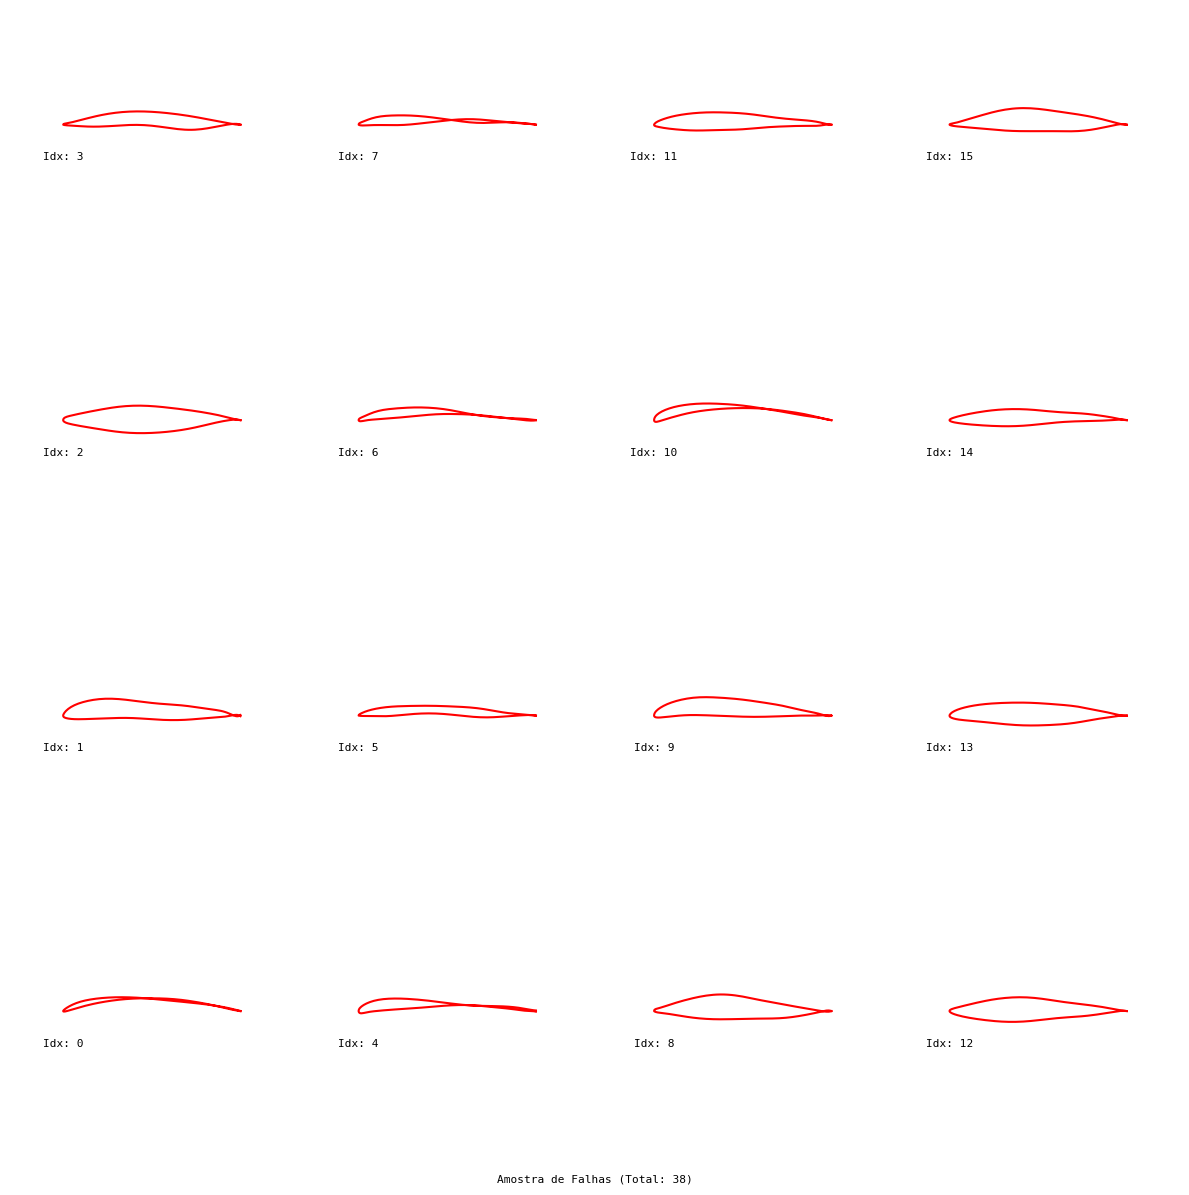

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Caso precise redefinir a robusta para garantir:
def check_validity_robust(coords):
    x = coords[:, 0]
    y = coords[:, 1]
    le_idx = np.argmin(x)
    
    upper_y = y[:le_idx+1][::-1]
    upper_x = x[:le_idx+1][::-1]
    lower_y = y[le_idx:]
    lower_x = x[le_idx:]

    common_x = np.linspace(0, 1, 100)
    
    try:
        y_up_interp = np.interp(common_x, upper_x, upper_y)
        y_low_interp = np.interp(common_x, lower_x, lower_y)
    except ValueError:
        return False 

    thickness = y_up_interp - y_low_interp
    if np.mean(thickness) < 0: thickness = -thickness # Aceita invertidos
    if np.any(thickness < -1e-3): return False
    return True

# 2. Encontrar os índices dos perfis ruins
print("Identificando perfis inválidos...")
invalid_indices = []
for i in range(len(coords)):
    # Use a mesma função que te deu os 91%
    if not check_validity_robust(coords[i]): 
        invalid_indices.append(i)

print(f"Encontrados {len(invalid_indices)} perfis inválidos.")

# 1. Recuperar as coordenadas dos perfis ruins
bad_airfoils_coords = [coords[i] for i in invalid_indices]

max_plot = 16
if len(bad_airfoils_coords) > max_plot:
    print(f"Muitos erros ({len(bad_airfoils_coords)}). Plotando os primeiros {max_plot}...")
    bad_airfoils_to_plot = bad_airfoils_coords[:max_plot]
else:
    bad_airfoils_to_plot = bad_airfoils_coords

# 2. Plotar usando sua nova função
if bad_airfoils_to_plot:
    plot_airfoil_list(
        bad_airfoils_to_plot,
        text_label=f"Amostra de Falhas (Total: {len(invalid_indices)})",
        color="red",         # Vermelho para destacar erro
        linestyle="-",
        figsize=(12, 12),    # Grande para ver os loops
        filename="invalid_airfoils.png",
        save_path="."        # Salva na pasta atual ou onde preferir
    )

### Smoothness (VOD)


DATASET GROUND TRUTH VOD (Real)
Mean VOD: 0.00000467
Std Dev:  0.00000315
Min VOD:  0.00000012
Max VOD:  0.00003733


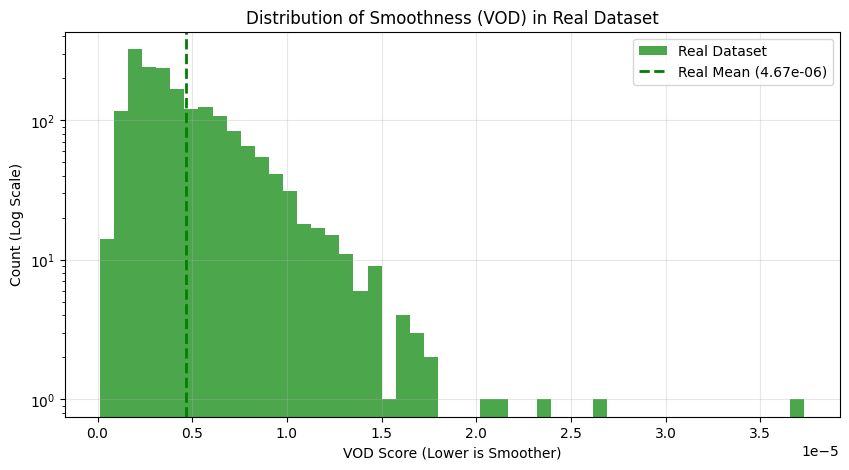

In [24]:
# ============================================================================
# 1. DATASET GROUND TRUTH VOD (SMOOTHNESS)
# ============================================================================
# VOD (Variance of Differences) measures the "roughness" of the curve.
# Lower values = Smoother airfoils.

train_df = pd.read_json(TRAIN_DATA_PATH)

# Concatenating train and validation dataframes
full_df = pd.concat([train_df, val_df], ignore_index=True)

# Converting coordinates from list to numpy arrays
full_df["coordinates"] = full_df["coordinates"].apply(np.array)

full_df["vod"] = full_df["coordinates"].apply(compute_vod_numpy)

vod_real = full_df["vod"].values

mean_vod_real = np.mean(vod_real)
std_vod_real = np.std(vod_real)
min_vod_real = np.min(vod_real)
max_vod_real = np.max(vod_real)

print("\n" + "="*40)
print("DATASET GROUND TRUTH VOD (Real)")
print("="*40)
print(f"Mean VOD: {mean_vod_real:.8f}")  # Target Baseline
print(f"Std Dev:  {std_vod_real:.8f}")
print(f"Min VOD:  {min_vod_real:.8f}")
print(f"Max VOD:  {max_vod_real:.8f}")
print("="*40)

# Plot Histogram - Real Data
plt.figure(figsize=(10, 5))
plt.hist(vod_real, bins=50, color='green', alpha=0.7, log=True, label="Real Dataset")
plt.axvline(x=mean_vod_real, color='green', linestyle='dashed', linewidth=2, label=f'Real Mean ({mean_vod_real:.2e})')
plt.title("Distribution of Smoothness (VOD) in Real Dataset")
plt.xlabel("VOD Score (Lower is Smoother)")
plt.ylabel("Count (Log Scale)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Generating 1822 airfoils...
Analyzing smoothness of 1822 generated airfoils...

GENERATED MODEL VOD (VAE)
Mean VOD: 0.00000459
Std Dev:  0.00000257
Min VOD:  0.00000047
Max VOD:  0.00002442


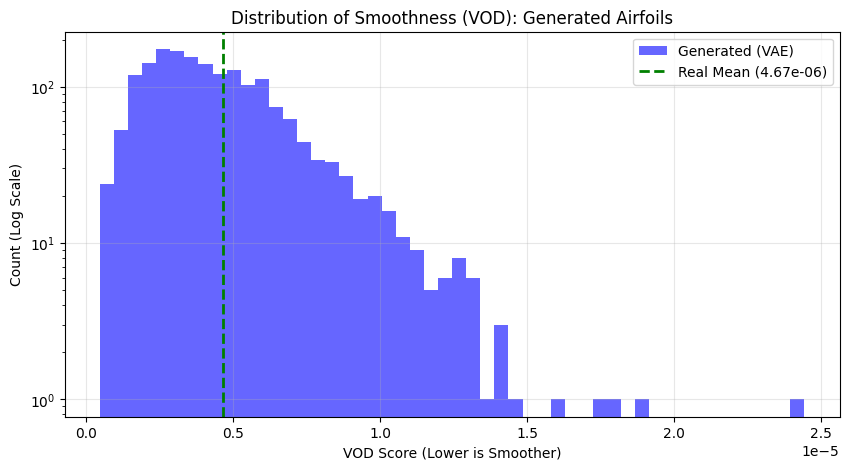

In [19]:
# ============================================================================
# 2. GENERATED MODEL VOD
# ============================================================================

BATCH_SIZE = full_df.shape[0] # Generate same number as dataset size
print(f"Generating {BATCH_SIZE} airfoils...")

dummy_latent_vector = tf.random.normal((BATCH_SIZE, LATENT_DIM))

_, w_norm, p_norm = vae.decoder(dummy_latent_vector)

w_norm = tf.reshape(w_norm, [-1, 2 * NPV])

w_phys, p_phys = vae.scaler.inverse_transform(w_norm.numpy(), p_norm.numpy())

w_phys_t = tf.convert_to_tensor(w_phys, dtype=tf.float32)
p_phys_t = tf.convert_to_tensor(p_phys, dtype=tf.float32)

w_phys_reshaped = tf.reshape(w_phys_t, [-1, 2, 12])

coords = vae.decoder.cst_transform(w_phys_reshaped, p_phys_t).numpy()

print(f"Analyzing smoothness of {len(coords)} generated airfoils...")

# A. Extract Y coordinates
y_coords_gen = coords[:, :, 1] 

# B. Calculate First Differences (Slopes)
diffs_gen = np.diff(y_coords_gen, axis=1)

# C. Calculate Variance of Differences (VOD)
vod_gen = np.var(diffs_gen, axis=1)

mean_vod_gen = np.mean(vod_gen)
std_vod_gen = np.std(vod_gen)
min_vod_gen = np.min(vod_gen)
max_vod_gen = np.max(vod_gen)

print("\n" + "="*40)
print("GENERATED MODEL VOD (VAE)")
print("="*40)
print(f"Mean VOD: {mean_vod_gen:.8f}") 
print(f"Std Dev:  {std_vod_gen:.8f}")
print(f"Min VOD:  {min_vod_gen:.8f}")
print(f"Max VOD:  {max_vod_gen:.8f}")
print("="*40)

# Plot Histogram - Generated Data
plt.figure(figsize=(10, 5))
plt.hist(vod_gen, bins=50, color='blue', alpha=0.6, label='Generated (VAE)', log=True)
# Add a vertical line for the Dataset Mean
plt.axvline(x=mean_vod_real, color='green', linestyle='dashed', linewidth=2, label=f'Real Mean ({mean_vod_real:.2e})')
plt.title("Distribution of Smoothness (VOD): Generated Airfoils")
plt.xlabel("VOD Score (Lower is Smoother)")
plt.ylabel("Count (Log Scale)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [26]:
# ============================================================================
# 3. RELATIVE VOD (Comparison)
# ============================================================================
# Relative VOD = Mean Generated VOD / Mean Real VOD
# Ideally, we want this to be close to 1.0 (matching reality) or < 1.0 (smoother than reality).
# > 1.0 means the generated airfoils are noisier/rougher than real ones.

relative_vod = mean_vod_gen / mean_vod_real

print("\n" + "="*40)
print(f"RELATIVE VOD (Rv)")
print("="*40)
print(f"Real Mean VOD:      {mean_vod_real:.8f}")
print(f"Generated Mean VOD: {mean_vod_gen:.8f}")
print("-" * 40)
print(f"Rv SCORE: {relative_vod:.4f}")
print("="*40)

# --- INTERPRETATION (Note: Logic is INVERTED compared to Diversity) ---
# For Diversity: Higher is Better.
# For VOD (Noise): Lower is Better.

if relative_vod <= 1.0:
    print(f"✅ EXCELLENT. Rv={relative_vod:.2f} <= 1.0")
    print("   The generated airfoils are as smooth (or smoother) than the real dataset.")
elif relative_vod <= 1.5:
    print(f"✅ GOOD. Rv={relative_vod:.2f}")
    print("   The generated airfoils have acceptable smoothness (slightly noisier than reference).")
    print("   XFoil should handle this fine.")
else:
    print(f"⚠️  WARNING. Rv={relative_vod:.2f} > 1.5")
    print("   The generated airfoils are significantly noisier/rougher than the training data.")
    print("   This might cause convergence issues in XFoil.")


RELATIVE VOD (Rv)
Real Mean VOD:      0.00000467
Generated Mean VOD: 0.00000459
----------------------------------------
Rv SCORE: 0.9834
✅ EXCELLENT. Rv=0.98 <= 1.0
   The generated airfoils are as smooth (or smoother) than the real dataset.


### Diversity

In [14]:
import numpy as np
from scipy.spatial.distance import cdist

def calculate_diversity_score(data_A, data_B=None):
    """
    Calculates the diversity score D as defined in the prompt.
    
    Formula: D(Y^(1), Y^(2)) = 1/n1 * sum_{i=1}^{n1} (min_{j=1}^{n2} ||Y^(1)_i - Y^(2)_j||^2)^0.5
    
    Parameters:
    -----------
    data_A : np.ndarray
        Dataset Y^(1) of shape (n1, n_features).
    data_B : np.ndarray, optional
        Dataset Y^(2) of shape (n2, n_features). 
        If None, calculates self-diversity D(Y^(1), Y^(1)) with diagonal exclusion.
        
    Returns:
    --------
    float
        The calculated diversity score.
    """
    # Ensure inputs are 2D arrays (flattening airfoils if necessary)
    A = np.asarray(data_A)
    if A.ndim > 2:
        A = A.reshape(A.shape[0], -1)
        
    if data_B is None:
        # Calculate Self-Diversity: D(Y, Y)
        # We must exclude the distance to itself (which is 0) to get a meaningful metric
        dists = cdist(A, A, metric='euclidean')
        np.fill_diagonal(dists, np.inf) # Ignore self-distance
        
        # min_{j} || Y_i - Y_j ||
        min_dists = np.min(dists, axis=1)
        
        # 1/n * sum(...)
        return np.mean(min_dists)
        
    else:
        # Calculate Diversity between datasets: D(Y^(1), Y^(2))
        B = np.asarray(data_B)
        if B.ndim > 2:
            B = B.reshape(B.shape[0], -1)
            
        dists = cdist(A, B, metric='euclidean')
        
        # min_{j} || Y^(1)_i - Y^(2)_j ||
        min_dists = np.min(dists, axis=1)
        
        return np.mean(min_dists)

def calculate_relative_diversity(generated_data, original_data):
    """
    Calculates Relative Diversity (RD).
    
    Definition: Ratio of the diversity of the generated dataset to the 
    self-diversity of the airfoil dataset.
    RD = D(Y_gen, Y_gen) / D(Y_orig, Y_orig)
    
    Interpretation:
    - RD > 1: Generated dataset is more diverse than original.
    - RD < 1: Generated dataset is less diverse (mode collapse).
    """
    div_gen = calculate_diversity_score(generated_data, None)
    div_orig = calculate_diversity_score(original_data, None)
    
    # Avoid division by zero
    if div_orig == 0:
        return np.inf
        
    return div_gen / div_orig

# ============================================================================
# DIVERSITY ANALYSIS 
# ============================================================================
print("Preparing data for diversity calculation...")

# 1. Obter dados brutos
real_coords_array = np.stack(full_df["coordinates"].values) # (N_real, 149, 2)
gen_coords_array = coords # (N_gen, 149, 2)

n_real = len(real_coords_array)
n_gen = len(gen_coords_array)

print(f"Original Real Size:      {n_real}")
print(f"Original Generated Size: {n_gen}")

# 2. DEFINIR O TAMANHO DE CORTE (O MÍNIMO ENTRE OS DOIS)
# Isso garante densidade comparável
n_samples = min(n_real, n_gen)

print(f"\nEqualizing sample sizes to N={n_samples} to avoid density bias...")

# 3. SUBSAMPLING (Aleatório para garantir justiça)
# Embaralha índices e pega os primeiros N
indices_real = np.random.choice(n_real, n_samples, replace=False)
indices_gen = np.random.choice(n_gen, n_samples, replace=False)

real_subset = real_coords_array[indices_real]
gen_subset = gen_coords_array[indices_gen]

print("\nCalculating Diversity Metrics on Equalized Subsets...")

# --- CÁLCULOS COM SUBSETS IGUAIS ---

# 1. Self-Diversity Real
div_real = calculate_diversity_score(real_subset)

# 2. Self-Diversity Gerado
div_gen = calculate_diversity_score(gen_subset)

# 3. Relative Diversity
rd_score = div_gen / div_real

# --- PRINT RESULTS ---
print("\n" + "="*40)
print(f"DIVERSITY METRICS RESULTS (N={n_samples})")
print("="*40)
print(f"Real Data Diversity:      {div_real:.6f}")
print(f"Generated Data Diversity: {div_gen:.6f}")
print("-" * 40)
print(f"Relative Diversity (RD):  {rd_score:.6f}")
print("="*40)

# --- INTERPRETATION ---
if rd_score >= 1.0:
    print(f"✅ EXCELLENT. RD={rd_score:.2f} >= 1.0")
    print("   The model explores the design space better than the training set.")
elif rd_score >= 0.8:
    print(f"✅ GOOD. RD={rd_score:.2f}")
    print("   Diversity is comparable to the real data.")
else:
    print(f"⚠️  WARNING. RD={rd_score:.2f}")
    print("   Potential Mode Collapse or generated samples are too clustered.")

Preparing data for diversity calculation...
Original Real Size:      1822
Original Generated Size: 5000

Equalizing sample sizes to N=1822 to avoid density bias...

Calculating Diversity Metrics on Equalized Subsets...

DIVERSITY METRICS RESULTS (N=1822)
Real Data Diversity:      0.031846
Generated Data Diversity: 0.038486
----------------------------------------
Relative Diversity (RD):  1.208491
✅ EXCELLENT. RD=1.21 >= 1.0
   The model explores the design space better than the training set.


### Latent Space Walk

In [27]:
af1 = Airfoil(name="NACA0004").to_kulfan_airfoil(NPV)
af2 = Airfoil(name="s1223").to_kulfan_airfoil(NPV)

af1_w = np.concatenate(
    (af1.kulfan_parameters["upper_weights"], 
     af1.kulfan_parameters["lower_weights"]), 
    axis=0
)
af1_p = np.array([af1.kulfan_parameters["TE_thickness"], af1.kulfan_parameters["leading_edge_weight"]])

af2_w = np.concatenate(
    (af2.kulfan_parameters["upper_weights"], 
     af2.kulfan_parameters["lower_weights"]), 
    axis=0
)
af2_p = np.array([af2.kulfan_parameters["TE_thickness"], af2.kulfan_parameters["leading_edge_weight"]])

af1_w = af1_w.reshape(1, -1)
af1_p = af1_p.reshape(1, -1)
af2_w = af2_w.reshape(1, -1)
af2_p = af2_p.reshape(1, -1)

af1_normalized = scaler.transform(af1_w, af1_p)
af2_normalized = scaler.transform(af2_w, af2_p)

af1_normalized_tensor = tf.convert_to_tensor(af1_normalized, dtype=tf.float32)
af2_normalized_tensor = tf.convert_to_tensor(af2_normalized, dtype=tf.float32)

_, af1_pred_w_norm, af1_pred_p_norm = vae(af1_normalized_tensor, training=False)
_, af2_pred_w_norm, af2_pred_p_norm = vae(af2_normalized_tensor, training=False)

af1_pred_w, af1_pred_p = scaler.inverse_transform(af1_pred_w_norm.numpy(), af1_pred_p_norm.numpy())
af2_pred_w, af2_pred_p = scaler.inverse_transform(af2_pred_w_norm.numpy(), af2_pred_p_norm.numpy())

af1_pred_coords = vae.decoder.cst_transform(af1_pred_w, af1_pred_p).numpy()
af2_pred_coords = vae.decoder.cst_transform(af2_pred_w, af2_pred_p).numpy()

af1_reconstructed = Airfoil(coordinates=af1_pred_coords[0], name="NACA0004_Reconstructed")
af1_reconstructed.draw()
af2_reconstructed = Airfoil(coordinates=af2_pred_coords[0], name="s1223_Reconstructed")
af2_reconstructed.draw()

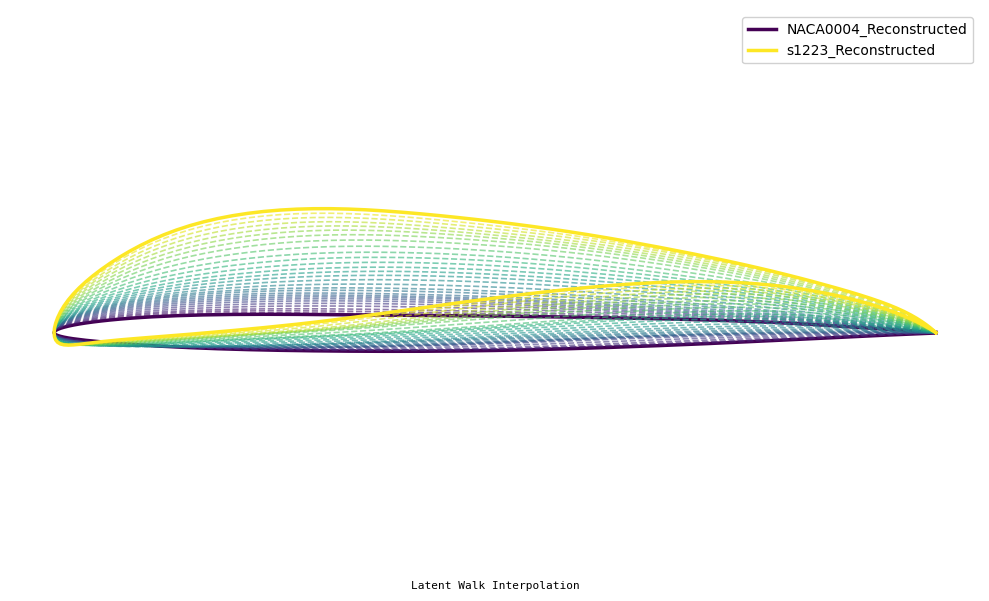

In [28]:
af1_latent_vector = vae.encoder(af1_normalized_tensor)
af2_latent_vector = vae.encoder(af2_normalized_tensor)

plot_latent_walk(
    vae_model=vae,
    start_point=af1_latent_vector,
    end_point=af2_latent_vector,
    num_steps=30,
    start_name=af1_reconstructed.name,   
    end_name=af2_reconstructed.name, 
    title="Interpolation Analysis",
    colorbar=False
)

Generating GIF...
GIF saved to: latent_walk.gif


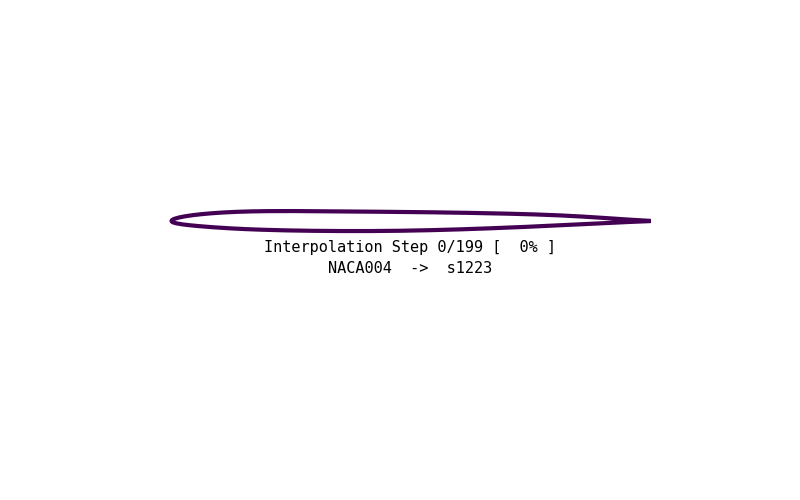

In [34]:
save_latent_walk_gif(vae, af1_latent_vector, af2_latent_vector, start_name="NACA004", end_name="s1223",  num_steps=200)

display(Image(filename="latent_walk.gif"))

### PCA e T-SNE

In [35]:
full_vectors = full_df["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["upper_weights"],     # Upper
    p["lower_weights"],     # Lower
    [p["TE_thickness"]],    # TE
    [p["leading_edge_weight"]] # LE
    ], axis=0)).to_list()

# Convert to Tensor (Physical Units)
full_tensor_phys = tf.convert_to_tensor(full_vectors, dtype=tf.float32)
full_weights_phys = full_tensor_phys[:, :24]
full_params_phys = full_tensor_phys[:, 24:]

# Normalize for Model Input
full_normalized = scaler.transform(full_weights_phys, full_params_phys)

Extraindo vetores latentes...
Calculando propriedades físicas para coloração...
Calculando PCA...
Calculando t-SNE (pode demorar um pouco)...


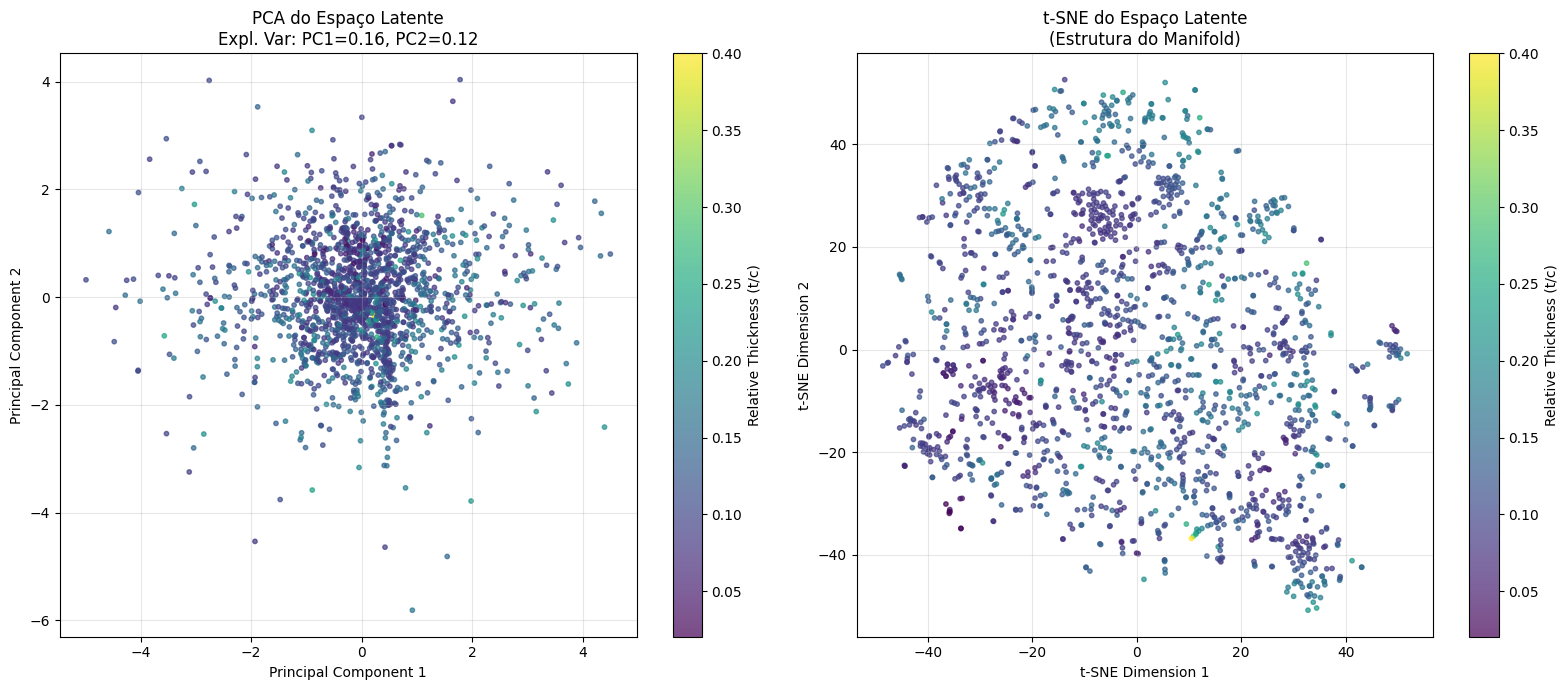

In [36]:
# ============================================================================
# 1. PREPARAR DADOS
# ============================================================================
# Vamos usar o conjunto de validação para isso
# Precisamos:
# A) Vetores Latentes (z_mean) -> Onde o VAE posicionou cada perfil
# B) Propriedades Físicas (Espessura) -> Para colorir o gráfico

print("Extraindo vetores latentes...")
# O encoder retorna (z_mean, z_log_var, z). Pegamos z_mean [0]
z_mean, _, = vae.encoder(full_normalized) 
z_mean = z_mean.numpy()

# Calcular Espessura Máxima para colorir (Meta-dado físico)
# (Assumindo que val_full_norm são os dados normalizados do val_df)
# Se você tiver a coluna de espessura no DataFrame original, use ela. 
# Caso contrário, calculamos rápido aqui:
print("Calculando propriedades físicas para coloração...")
thicknesses = []

# Denormalizar para calcular física real
w_phys, p_phys = vae.scaler.inverse_transform(full_normalized[:, :24], full_normalized[:, 24:])
w_phys_t = tf.reshape(tf.convert_to_tensor(w_phys, dtype=tf.float32), [-1, 2, 12])
p_phys_t = tf.convert_to_tensor(p_phys, dtype=tf.float32)
coords_all = vae.decoder.cst_transform(w_phys_t, p_phys_t).numpy()

for coords in coords_all:
    # Espessura máx: max(Upper - Lower)
    # Assumindo ordem correta dos pontos, ou calculando max(Y) - min(Y) aprox
    t_max = np.max(coords[:, 1]) - np.min(coords[:, 1])
    thicknesses.append(t_max)

thicknesses = np.array(thicknesses)

# ============================================================================
# 2. PCA (Análise Global)
# ============================================================================
print("Calculando PCA...")
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)
explained_var = pca.explained_variance_ratio_

# ============================================================================
# 3. t-SNE (Análise Local/Manifold)
# ============================================================================
print("Calculando t-SNE (pode demorar um pouco)...")
# Perplexity=30 é padrão. Se tiver muitos dados (>10k), aumente para 50.
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
z_tsne = tsne.fit_transform(z_mean)

# ============================================================================
# 4. PLOTAGEM
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot PCA ---
sc1 = axes[0].scatter(z_pca[:, 0], z_pca[:, 1], c=thicknesses, cmap='viridis', s=10, alpha=0.7)
axes[0].set_title(f'PCA do Espaço Latente\nExpl. Var: PC1={explained_var[0]:.2f}, PC2={explained_var[1]:.2f}')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
plt.colorbar(sc1, ax=axes[0], label='Relative Thickness (t/c)')
axes[0].grid(True, alpha=0.3)

# --- Plot t-SNE ---
sc2 = axes[1].scatter(z_tsne[:, 0], z_tsne[:, 1], c=thicknesses, cmap='viridis', s=10, alpha=0.7)
axes[1].set_title('t-SNE do Espaço Latente\n(Estrutura do Manifold)')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
plt.colorbar(sc2, ax=axes[1], label='Relative Thickness (t/c)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

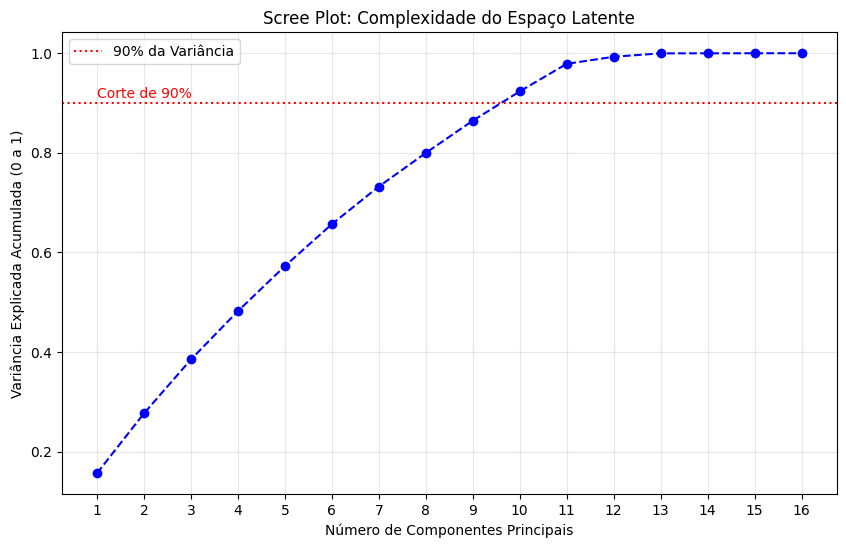

Variância Total com 16 componentes: 100.00%
Número de componentes para atingir 90%: 10


In [37]:
# 1. Ajuste o PCA para calcular TODOS os componentes (Latent Dim = 16)
pca_full = PCA(n_components=None) # None = usa todas as dimensões disponíveis
pca_full.fit(z_mean)

# 2. Dados para o gráfico
variancia_acumulada = np.cumsum(pca_full.explained_variance_ratio_)
num_componentes = np.arange(1, len(variancia_acumulada) + 1)

# 3. Plotagem do Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(num_componentes, variancia_acumulada, marker='o', linestyle='--', color='b')

# Linha de corte de 90% (Referência visual importante)
plt.axhline(y=0.90, color='r', linestyle=':', label='90% da Variância')
plt.text(1, 0.91, 'Corte de 90%', color='r', fontsize=10)

plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada (0 a 1)')
plt.title('Scree Plot: Complexidade do Espaço Latente')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(num_componentes) # Mostra todos os números no eixo X
plt.show()

# Print para você citar no texto
print(f"Variância Total com 16 componentes: {variancia_acumulada[-1]:.2%}")
n_90 = np.argmax(variancia_acumulada >= 0.90) + 1
print(f"Número de componentes para atingir 90%: {n_90}")

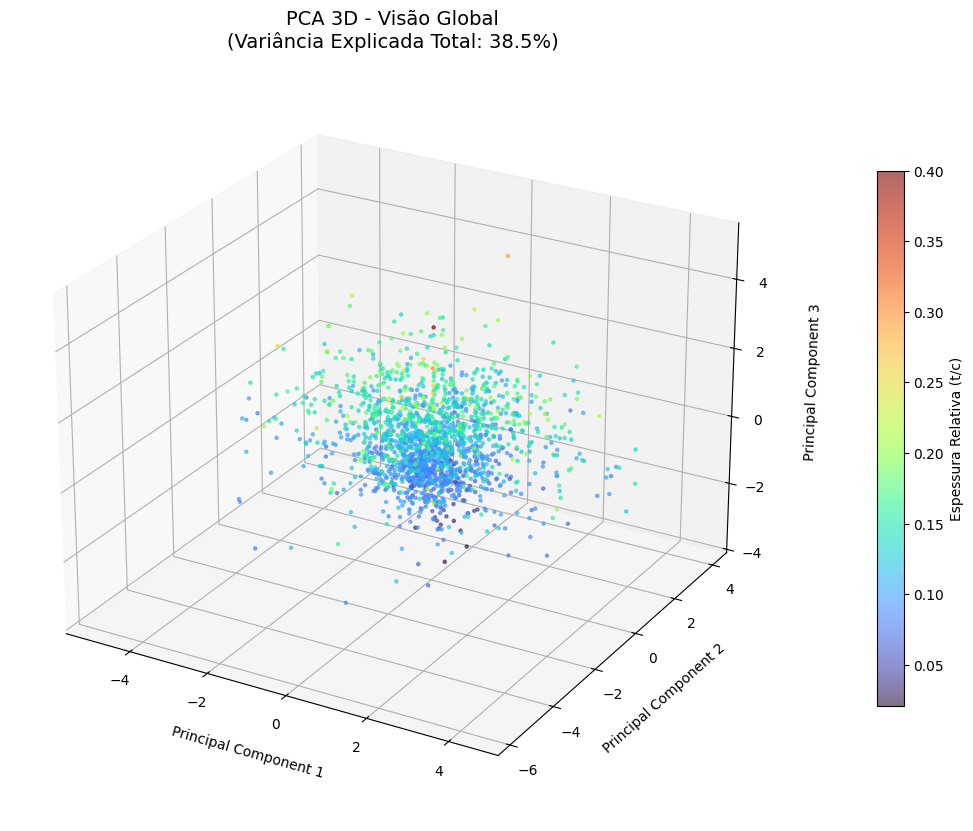

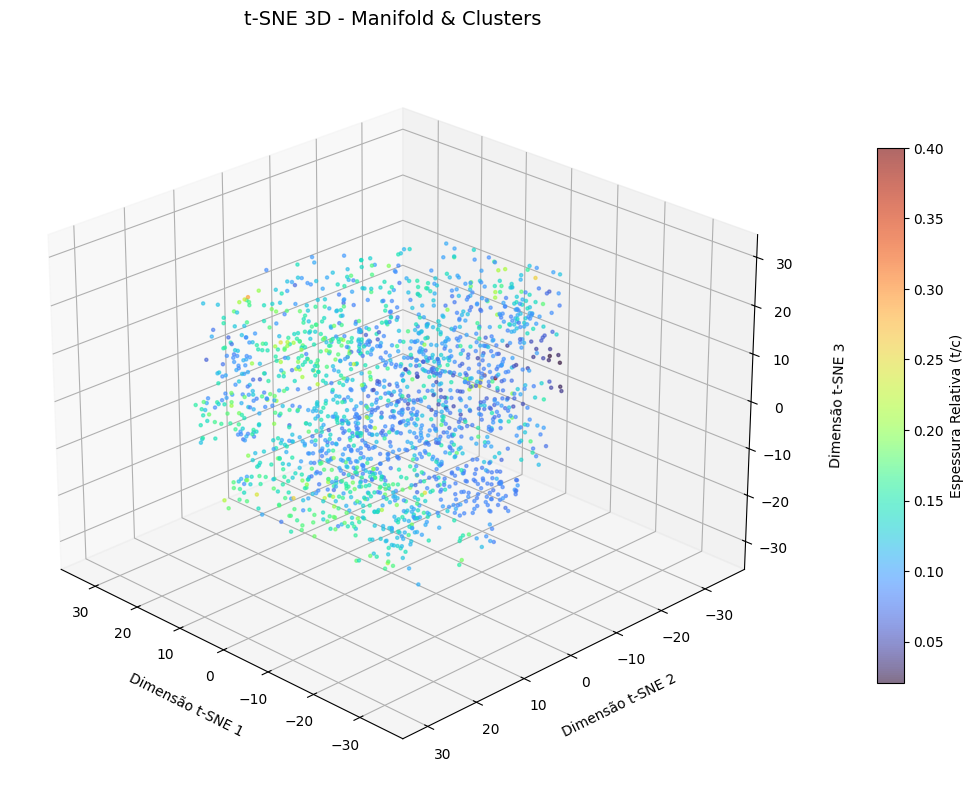

In [47]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# ============================================================================
# FIGURA 1: PCA 3D (Com correção de margens)
# ============================================================================
fig1 = plt.figure(figsize=(12, 9)) # Aumentei um pouco a figura
ax1 = fig1.add_subplot(111, projection='3d')

# Plotagem
sc1 = ax1.scatter(
    z_pca_3d[:, 0], z_pca_3d[:, 1], z_pca_3d[:, 2], 
    c=thicknesses, cmap='turbo', s=5, alpha=0.6
)

# Estilização
ax1.set_title(f'PCA 3D - Visão Global\n(Variância Explicada Total: {var_explicada_3d:.1%})', fontsize=14)
ax1.set_xlabel('Principal Component 1', fontsize=10, labelpad=10)
ax1.set_ylabel('Principal Component 2', fontsize=10, labelpad=10)

# CORREÇÃO AQUI: labelpad ajustado e rotação do label se necessário
ax1.set_zlabel('Principal Component 3', fontsize=10, labelpad=15)

# Ajuste do ângulo para tentar afastar o eixo Z da borda esquerda
ax1.view_init(elev=25, azim=-60) 

# Barra de Cores
cbar1 = plt.colorbar(sc1, ax=ax1, label='Espessura Relativa (t/c)', shrink=0.7, pad=0.1)

# CORREÇÃO FINAL: Margens manuais em vez de tight_layout
# left=0.0 e right=1.0 ocupam tudo, então damos uma margem (0.1)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)

plt.show()

# ============================================================================
# FIGURA 2: t-SNE 3D (Recuperada e Ajustada)
# ============================================================================
fig2 = plt.figure(figsize=(12, 9))
ax2 = fig2.add_subplot(111, projection='3d')

# Plotagem
sc2 = ax2.scatter(
    z_tsne_3d[:, 0], z_tsne_3d[:, 1], z_tsne_3d[:, 2], 
    c=thicknesses, cmap='turbo', s=5, alpha=0.6
)

# Estilização
ax2.set_title('t-SNE 3D - Manifold & Clusters', fontsize=14)
ax2.set_xlabel('Dimensão t-SNE 1', fontsize=10, labelpad=10)
ax2.set_ylabel('Dimensão t-SNE 2', fontsize=10, labelpad=10)
ax2.set_zlabel('Dimensão t-SNE 3', fontsize=10, labelpad=15)

# Ângulo de visão sugerido para ver a profundidade
ax2.view_init(elev=25, azim=135)

# Barra de Cores
cbar2 = plt.colorbar(sc2, ax=ax2, label='Espessura Relativa (t/c)', shrink=0.7, pad=0.1)

# Ajuste manual de margens para evitar cortes (Igual ao PCA)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)

plt.show()